In [17]:
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

path = "../latex/figures/"
ratinabox.stylize_plots()
ratinabox.autosave_plots = False
ratinabox.figure_directory = path 

In [18]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

In [19]:
batch_size = 10
seq_length = 10
# filename = "../data/tensor.pt"
x = torch.zeros([batch_size, seq_length, 2], dtype=torch.float32)
y = torch.zeros([batch_size, seq_length, 2], dtype=torch.float32)
for i in range(batch_size):
    env = Environment()
    ag = Agent(env)

    for _ in range(seq_length):
        ag.update()

    x[i, :, :] = torch.tensor(ag.history["vel"])
    y[i, :, :] = torch.tensor(ag.history["pos"])

In [20]:
# Pre-process data? If so, do it before creating a dataloader:

In [21]:
joint_data = TensorDataset(x, y)
data_loader = DataLoader(dataset=joint_data, batch_size=batch_size, shuffle=True)

In [22]:
# print(joint_data.shape)
# for e in data_loader:
#     print(f"x: {e[0]} \ty: {e[1]}")
# print(data_loader)

In [23]:
import torch.nn as nn 
learning_rate = 0.001
num_epochs = 200
hidden_size = 7

loss_func = nn.MSELoss(reduction="mean")
input_size = 2
output_size = 2
model = nn.RNN(input_size=input_size, 
               hidden_size=hidden_size, 
               num_layers=1, 
               batch_first=True, 
               device="cpu")
decoder = nn.Linear(in_features=hidden_size, 
                    out_features=2, 
                    bias=False)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

In [24]:
for epoch in range(num_epochs):
    for x_batch, y_batch in data_loader:
        # Get the predicted element equivalent to model(x_batch)[:, 0]
        out_h, hh = model(x_batch)
        y_tilde = decoder(out_h)
        
        # Calculate the loss using the correct dimension
        loss = loss_func(y_tilde, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 10 == 0:
        pass
        # print(f"Epoch {epoch} - Loss {loss.item():.4f}")

In [25]:
# print(f"Final parameters: \n{model.get_parameter("weight_hh_l0")}")

In [26]:
import matplotlib.pyplot as plt
pred_traj = y_tilde.detach().numpy()
true_traj = y_batch.detach().numpy()
pred_traj.shape

(10, 10, 2)

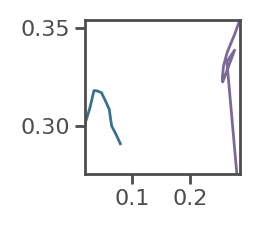

In [27]:
fig, ax = plt.subplots()
ax.plot(pred_traj[1, :, 0], pred_traj[1, :, 1])
ax.plot(true_traj[1, :, 0], true_traj[1, :, 1])

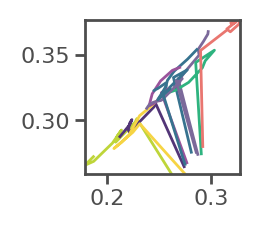

In [28]:
fig, ax = plt.subplots()
for i in range(batch_size):
    x = pred_traj[i, :, 0]
    y = pred_traj[i, :, 1]
    ax.plot(x, y)

In [29]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, batch_size):
        super(VanillaRNN, self).__init__()
        # Input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_length = seq_length
        self.batch_size = batch_size

        # Network architecture
        # Use "encoder" and "decoder" to handle weights inp-hidden and hidden-hidden
        self.input_layer = nn.Linear(in_features=self.input_size,
                                     out_features=hidden_size, 
                                     bias=False)
        self.rnn = nn.RNN(input_size=self.input_size, 
                          hidden_size=self.hidden_size, 
                          num_layers=1,
                          nonlinearity="relu",
                          bias=False,
                          batch_first=True)
        self.output_layer = nn.Linear(in_features=self.hidden_size,
                                      out_features=self.output_size,
                                      bias=False)
        
    def forward(self, data):
        # Give a starting position to initiate the hidden state
        # Could put this into a helper function or use encoder/decoder
        vel, x0 = data 
        h0 = self.input_layer(x0[:, 0])
        # print(h0[None].size())
        out, _ = self.rnn(vel, h0[None])
        return out

    def predict(self, data):
        y_tilde = self.output_layer(self.forward(data))
        return y_tilde
    
    def loss_function(self):
        # Define loss function which ensures conformal isometry?
        # Not needed for project-1
        pass


In [30]:
rnn = VanillaRNN(input_size, hidden_size, output_size, seq_length, batch_size)
loss_f = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [31]:
for epoch in range(num_epochs):
    for x_batch, y_batch in data_loader:
        # Get the predicted element equivalent to model(x_batch)[:, 0]
        y_tilde = rnn.predict((x_batch, y_batch))
        # plt.plot(y_batch[:,0,:])
        # Calculate the loss using the correct dimension
        loss = loss_f(y_tilde, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss {loss.item():.4f}")

Epoch 0 - Loss 0.1473
Epoch 10 - Loss 0.1458


Epoch 20 - Loss 0.1445
Epoch 30 - Loss 0.1435
Epoch 40 - Loss 0.1426
Epoch 50 - Loss 0.1419
Epoch 60 - Loss 0.1413
Epoch 70 - Loss 0.1406
Epoch 80 - Loss 0.1398
Epoch 90 - Loss 0.1390
Epoch 100 - Loss 0.1379
Epoch 110 - Loss 0.1364
Epoch 120 - Loss 0.1341
Epoch 130 - Loss 0.1303
Epoch 140 - Loss 0.1223
Epoch 150 - Loss 0.1053
Epoch 160 - Loss 0.0919
Epoch 170 - Loss 0.0793
Epoch 180 - Loss 0.0705
Epoch 190 - Loss 0.0640


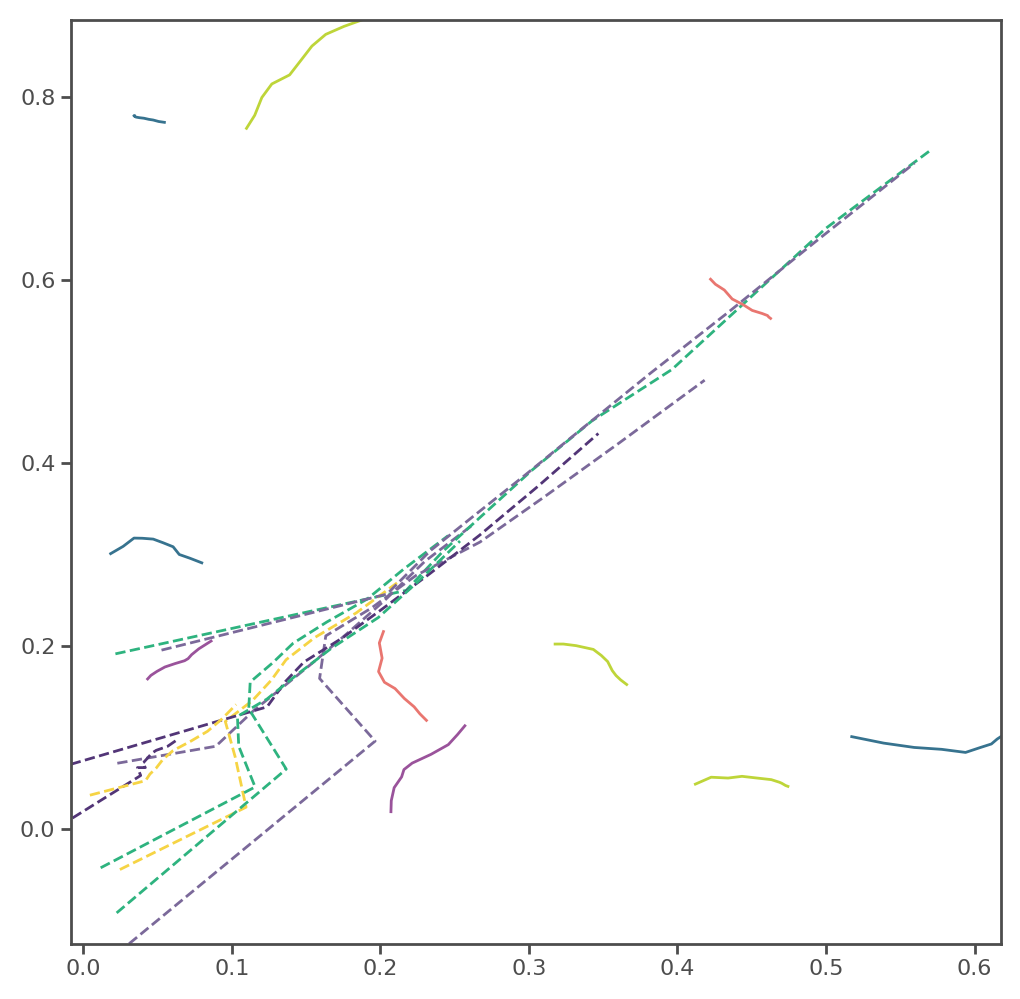

In [32]:
pred_traj = y_tilde.detach().numpy()
true_traj = y_batch.detach().numpy()

fig, ax = plt.subplots(figsize=(6,6))

for i in range(batch_size):
    ax.plot(pred_traj[i, :, 0], pred_traj[i, :, 1], "--")
    ax.plot(true_traj[i, :, 0], true_traj[i, :, 1])

Open data rat foraging Sargollini